In [ ]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment140:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2477%2F4140%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240822%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240822T134558Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8df97ef501a99e4e176f672c1dca82d79feed5f32e27f3c8e02e891c06d8cd56f2ae0ac38ced8bdd8c55b916092361d2f4935ec851af20f89ecd5d0973e1f54681e779e6a978968e4222c944759c6da54a3442faebd8bfbe078bf2bff802ef9c1b33ba66d9dca61dfe295150a42e1f9133369d6d29940d57261bc2a5a1f238349b00ba6aa826a9bbbc6457a4ca8ce31b007843d096fae85c194b1cf381ab731a0fe4e61096aa807136e8d19efd5addb72bb874994c3a236a882baa02d9eab39ebc99626537c20d72a835a7ea0d30274c6d3b8be561b3e027defa71717c10174d8606f9fb5b6565f90fad853f9b21882229f269ea1d55797c5d583eeff9bff563'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 84855679 bytes downloaded
Downloaded and uncompressed: sentiment140
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]

In [ ]:
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [ ]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [ ]:
print('lenght of data is', len(data))

lenght of data is 1599999


In [ ]:
data.shape

(1599999, 6)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
data.dtypes

,0
label,int64
time,int64
date,object
query,object
username,object
text,object


In [ ]:
np.sum(data.isnull().any(axis=1))

0

In [ ]:
print('Count of columns in the data is:  ', len(data.columns))

Count of columns in the data is:   6


In [ ]:
print('Count of rows in the data is:  ', len(data))

Count of rows in the data is:   1599999


In [ ]:
data=data[['text','label']]

In [ ]:
data['label'][data['label']==4]=1

In [ ]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [ ]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [ ]:
data = pd.concat([data_pos, data_neg])

In [ ]:
data['text']=data['text'].str.lower()

In [ ]:
data['text'].tail()

,text
19995,one more day of holidays
19996,feeling so down right now .. i hate you damn h...
19997,"geez,i hv to read the whole book of personalit..."
19998,i threw my sign at donnie and he bent over to ...
19999,@heather2711 good thing i didn't find any then...


In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

,text
799999,love @health4uandpets u guys r best!!
800000,im meeting one besties tonight! cant wait!! - ...
800001,"@darealsunisakim thanks twitter add, sunisa! g..."
800002,sick really cheap hurts much eat real food plu...
800003,@lovesbrooklyn2 effect everyone


In [ ]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [ ]:
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

,text
19995,one day holidays
19996,feeling right hate damn humprey
19997,geezi hv read whole book personality types emb...
19998,threw sign donnie bent get thingee made sad face
19999,heather2711 good thing find none ones like com...


In [ ]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

,text
19995,one day holidays
19996,feling right hate damn humprey
19997,gezi hv read whole bok personality types embar...
19998,threw sign donie bent get thinge made sad face
19999,heather271 god thing find none ones like come ...


In [ ]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

In [ ]:
data['text']= data['text'].apply(lambda x: cleaning_email(x))
data['text'].tail()

,text
19995,one day holidays
19996,feling right hate damn humprey
19997,gezi hv read whole bok personality types embar...
19998,threw sign donie bent get thinge made sad face
19999,heather271 god thing find none ones like come ...


In [ ]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

In [ ]:
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

,text
19995,one day holidays
19996,feling right hate damn humprey
19997,gezi hv read whole bok personality types embar...
19998,threw sign donie bent get thinge made sad face
19999,heather271 god thing find none ones like come ...


In [ ]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [ ]:
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

,text
19995,one day holidays
19996,feling right hate damn humprey
19997,gezi hv read whole bok personality types embar...
19998,threw sign donie bent get thinge made sad face
19999,heather god thing find none ones like come siz...


In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

In [ ]:
data['text'].head()

,text
799999,"[love, healthuandpets, u, guys, r, best]"
800000,"[im, meting, one, besties, tonight, cant, wait..."
800001,"[darealsunisakim, thanks, twiter, ad, sunisa, ..."
800002,"[sick, realy, cheap, hurts, much, eat, real, f..."
800003,"[lovesbroklyn, efect, everyone]"


In [ ]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

In [ ]:
data['text'].head()

,text
799999,"[love, healthuandpets, u, guys, r, best]"
800000,"[im, meting, one, besties, tonight, cant, wait..."
800001,"[darealsunisakim, thanks, twiter, ad, sunisa, ..."
800002,"[sick, realy, cheap, hurts, much, eat, real, f..."
800003,"[lovesbroklyn, efect, everyone]"


In [ ]:
import nltk
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data['text'].head()

,text
799999,"[love, healthuandpets, u, guys, r, best]"
800000,"[im, meting, one, besties, tonight, cant, wait..."
800001,"[darealsunisakim, thanks, twiter, ad, sunisa, ..."
800002,"[sick, realy, cheap, hurts, much, eat, real, f..."
800003,"[lovesbroklyn, efect, everyone]"


In [ ]:
X=data.text
y=data.label

In [ ]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
sequences_matrix.shape

(40000, 500)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [ ]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

In [ ]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 120s 376ms/step - accuracy: 0.5846 - loss: 0.6617 - val_accuracy: 0.7339 - val_loss: 0.5316
Epoch 2/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 146s 464ms/step - accuracy: 0.7515 - loss: 0.5114 - val_accuracy: 0.7343 - val_loss: 0.5220
Epoch 3/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 173s 372ms/step - accuracy: 0.7616 - loss: 0.4972 - val_accuracy: 0.7414 - val_loss: 0.5237
Epoch 4/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 368ms/step - accuracy: 0.7543 - loss: 0.5114 - val_accuracy: 0.7339 - val_loss: 0.5274
Epoch 5/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 115s 365ms/step - accuracy: 0.7697 - loss: 0.4795 - val_accuracy: 0.7396 - val_loss: 0.5255
Epoch 6/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 363ms/step - accuracy: 0.7784 - loss: 0.4699 - val_accuracy: 0.7389 - val_loss: 0.5285
Training finished !!


In [ ]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.7409 - loss: 0.5248


In [ ]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

In [ ]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)

375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step


In [ ]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

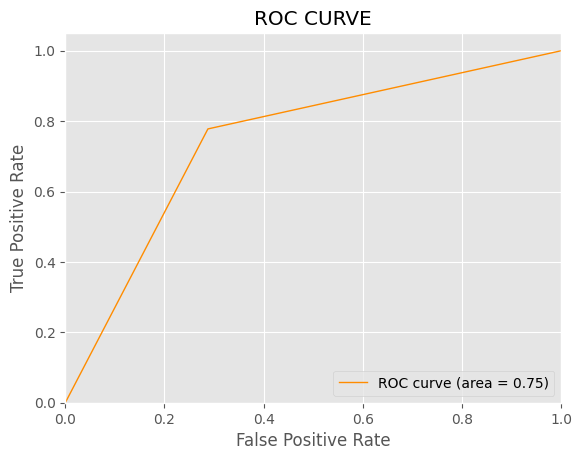

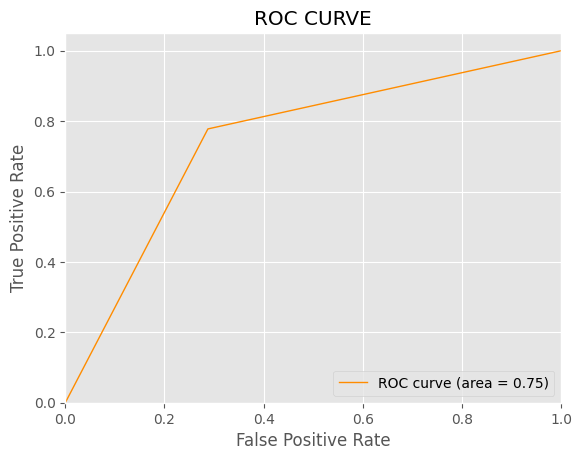

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()